Step 1: Import Libraries

In [1]:
# Basic libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# For reproducibility
np.random.seed(42)


📊 Step 2: Generate Synthetic Data

In [2]:
# Number of records
n = 1200  # >1000 rows

# Generate synthetic features
data = {
    'MEMBER_ID': range(1, n+1),
    'AGE': np.random.randint(21, 65, n),
    'GENDER': np.random.choice(['Male', 'Female'], n, p=[0.55, 0.45]),
    'ACCOUNT_AGE_MONTHS': np.random.randint(6, 180, n),
    'MONTHLY_DEPOSITS': np.random.normal(20000, 8000, n).clip(2000, 50000),
    'LOAN_ACTIVITY': np.random.choice([0, 1], n, p=[0.4, 0.6]),
    'LOAN_REPAYMENT_HISTORY': np.random.uniform(50, 100, n),
    'COMPLAINTS_COUNT': np.random.poisson(1.2, n),
    'TRANSACTION_FREQUENCY': np.random.randint(1, 20, n),
    'DIGITAL_USAGE': np.random.randint(0, 100, n)
}

df = pd.DataFrame(data)

# Create a churn probability based on weighted factors
churn_prob = (
    (df['COMPLAINTS_COUNT'] * 0.15) +
    ((100 - df['LOAN_REPAYMENT_HISTORY']) * 0.1) +
    ((20 - df['TRANSACTION_FREQUENCY']) * 0.05) +
    ((12 - (df['ACCOUNT_AGE_MONTHS']/12)) * 0.05) +
    ((50 - df['DIGITAL_USAGE']) * 0.05)
)

# Normalize probabilities
churn_prob = (churn_prob - churn_prob.min()) / (churn_prob.max() - churn_prob.min())

# Create binary churn variable
df['CHURNED'] = np.where(np.random.rand(n) < churn_prob, 1, 0)

# Ensure no negative values
df['MONTHLY_DEPOSITS'] = df['MONTHLY_DEPOSITS'].abs()

df.head()


,MEMBER_ID,AGE,GENDER,ACCOUNT_AGE_MONTHS,MONTHLY_DEPOSITS,LOAN_ACTIVITY,LOAN_REPAYMENT_HISTORY,COMPLAINTS_COUNT,TRANSACTION_FREQUENCY,DIGITAL_USAGE,CHURNED
0,1,59,Male,52,23662.182929,1,90.642549,1,13,99,0
1,2,49,Male,148,33395.939467,0,78.937824,1,5,44,0
2,3,35,Male,109,19955.231849,1,80.914251,1,16,79,1
3,4,63,Male,47,25349.933245,0,89.073104,2,16,24,1
4,5,28,Female,65,11266.392991,0,85.163861,0,16,77,0


📈 Step 3: Exploratory Data Analysis (EDA)

Dataset shape: (1200, 11)
CHURNED
1    610
0    590
Name: count, dtype: int64


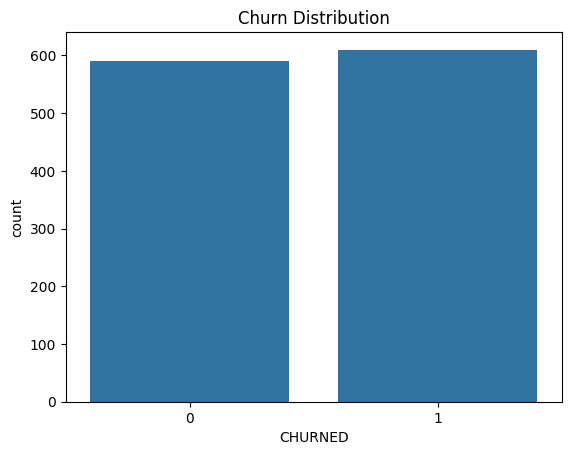

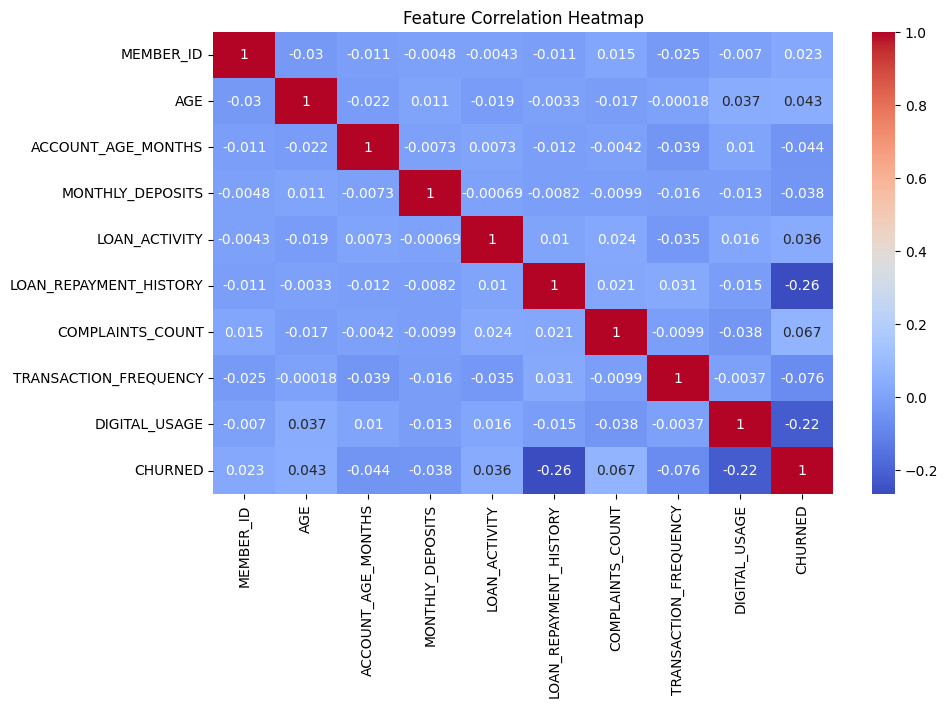

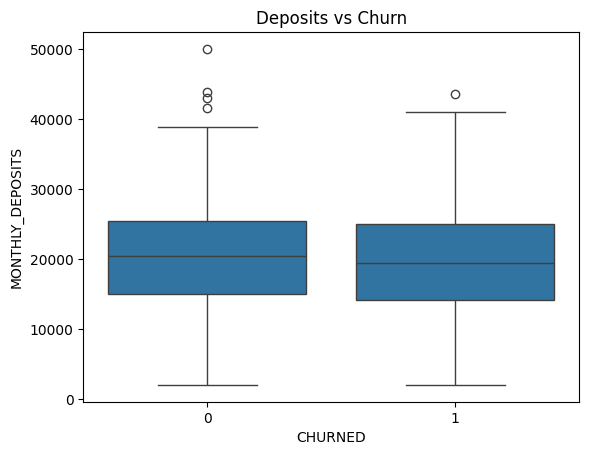

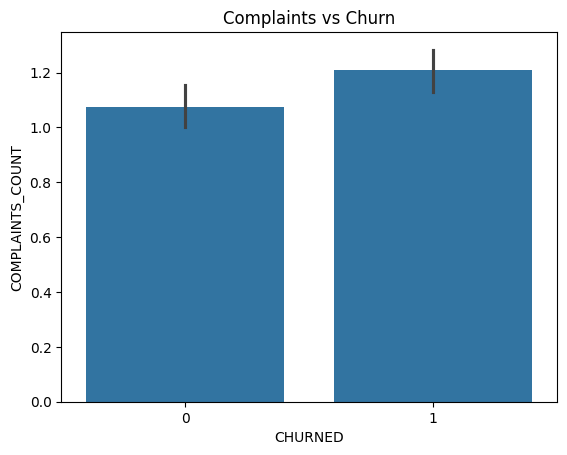

In [3]:
print("Dataset shape:", df.shape)
print(df['CHURNED'].value_counts())

# Plot churn distribution
sns.countplot(data=df, x='CHURNED')
plt.title('Churn Distribution')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Relationship examples
sns.boxplot(x='CHURNED', y='MONTHLY_DEPOSITS', data=df)
plt.title('Deposits vs Churn')
plt.show()

sns.barplot(x='CHURNED', y='COMPLAINTS_COUNT', data=df)
plt.title('Complaints vs Churn')
plt.show()


Step 4: Data Preprocessing

In [4]:
# Convert categorical variable
df['GENDER'] = df['GENDER'].map({'Male': 1, 'Female': 0})

# Split features and target
X = df.drop(['MEMBER_ID', 'CHURNED'], axis=1)
y = df['CHURNED']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale numerical data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Step 5: Train Models (Logistic Regression + XGBoost)

In [5]:
# Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train)
log_preds = log_model.predict(X_test_scaled)

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)


Step 6: Evaluate Models

=== Logistic Regression ===
Accuracy: 0.6375
ROC-AUC: 0.6850514031675465
              precision    recall  f1-score   support

           0       0.65      0.58      0.61       118
           1       0.63      0.70      0.66       122

    accuracy                           0.64       240
   macro avg       0.64      0.64      0.64       240
weighted avg       0.64      0.64      0.64       240


=== XGBoost ===
Accuracy: 0.575
ROC-AUC: 0.6346901917199222
              precision    recall  f1-score   support

           0       0.57      0.55      0.56       118
           1       0.58      0.60      0.59       122

    accuracy                           0.57       240
   macro avg       0.57      0.57      0.57       240
weighted avg       0.57      0.57      0.57       240



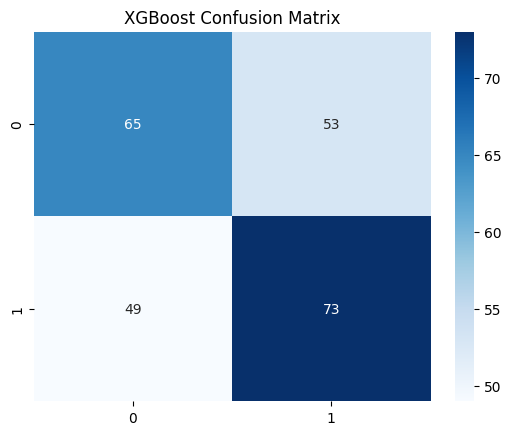

In [6]:
# Logistic Regression Results
print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, log_preds))
print("ROC-AUC:", roc_auc_score(y_test, log_model.predict_proba(X_test_scaled)[:,1]))
print(classification_report(y_test, log_preds))

# XGBoost Results
print("\n=== XGBoost ===")
print("Accuracy:", accuracy_score(y_test, xgb_preds))
print("ROC-AUC:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1]))
print(classification_report(y_test, xgb_preds))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.show()


Step 7: Feature Importance (XGBoost)

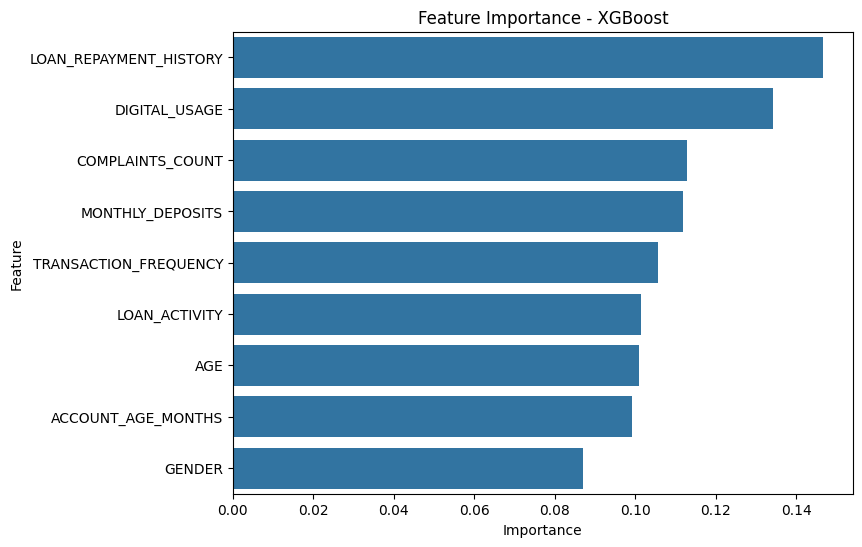

In [7]:
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(y='Feature', x='Importance', data=importance)
plt.title('Feature Importance - XGBoost')
plt.show()


Step 8: Save the Model (for Dashboard Integration)

In [8]:
import joblib

joblib.dump(xgb_model, 'churn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("✅ Model and scaler saved successfully!")


✅ Model and scaler saved successfully!


Step 9: Predict New Members’ Churn Probability

In [9]:
# Example new data
new_members = pd.DataFrame({
    'AGE': [40, 55],
    'GENDER': [1, 0],
    'ACCOUNT_AGE_MONTHS': [36, 12],
    'MONTHLY_DEPOSITS': [25000, 5000],
    'LOAN_ACTIVITY': [1, 0],
    'LOAN_REPAYMENT_HISTORY': [90, 60],
    'COMPLAINTS_COUNT': [0, 3],
    'TRANSACTION_FREQUENCY': [10, 2],
    'DIGITAL_USAGE': [80, 20]
})

# Predict churn probabilities
probs = xgb_model.predict_proba(new_members)[:,1]
new_members['CHURN_PROBABILITY'] = np.round(probs, 3)

new_members


,AGE,GENDER,ACCOUNT_AGE_MONTHS,MONTHLY_DEPOSITS,LOAN_ACTIVITY,LOAN_REPAYMENT_HISTORY,COMPLAINTS_COUNT,TRANSACTION_FREQUENCY,DIGITAL_USAGE,CHURN_PROBABILITY
0,40,1,36,25000,1,90,0,10,80,0.016
1,55,0,12,5000,0,60,3,2,20,0.983
